In [5]:
import numpy as np
import matplotlib.pylab as plt
from library import *
from tqdm import tqdm
import random
from math import *

In [6]:
"""declaring global constants"""
avogadro = 6.02214086e23
boltzmann = 1.38064852e-23
ndim = 3

In [7]:
T_i_ = np.zeros(10000)
step_ = np.zeros(10000)
etot_avg_ = np.zeros(10000)
P_ = np.zeros(10000)
Z_ = np.zeros(10000)
KE_= np.zeros(10000)
PE_= np.zeros(10000)
rho_ = np.zeros(10000)
v_ = np.zeros(10000)
v2_ = np.zeros(10000)

This Python script is a molecular dynamics simulation using the Langevin dynamics approach. It simulates a system of particles interacting via a Lennard-Jones potential in a periodic box. The simulation includes a thermostat to maintain a constant temperature.

Here's a breakdown of the script:

1. **Parameters**: The script starts by defining several parameters, including the number of dimensions (`dim`), the number of steps in the simulation (`n_steps`), the number of particles (`n`), the time step (`dt`), the target temperature (`T_0`), the Lennard-Jones parameters (`sig` and `eps`), the cutoff radius (`r_ctf`), and the box size (`bs`).

2. **Initialization**: The script initializes arrays to hold the positions, velocities, and accelerations of the particles. The positions and velocities are initially set to random values.

3. **Center of Mass (COM)**: The script calculates the center of mass of the system and shifts the positions of the particles so that the center of mass is at the origin.

4. **Main Loop**: The script enters the main loop, which runs for `n_steps` iterations. In each iteration, the script:
   - Applies periodic boundary conditions to the positions.
   - Calculates the forces on each particle due to the Lennard-Jones potential.
   - Updates the positions of the particles using the velocities and accelerations.
   - Calculates the instantaneous temperature of the system.
   - Updates the velocities of the particles using the accelerations and the scaling factor from the thermostat.
   - Calculates the instantaneous pressure and compressibility factor (`Z`).
   - Writes the step number, time, kinetic energy, potential energy, total energy, temperature, pressure, and `Z` to output files.
   - If the step number is greater than `ign`, accumulates the kinetic energy, potential energy, temperature, and pressure for later averaging.

5. **Statistical Averages**: After the main loop, the script calculates and prints the average temperature, pressure, kinetic energy, potential energy, and total energy over the steps after `ign`.

6. **File Closing**: Finally, the script closes the output files.

This script is a basic example of a molecular dynamics simulation. It could be extended in many ways, such as by adding support for different potential energy functions, implementing different thermostats or barostats, or including additional analysis of the simulation results.

In [8]:
#PARAMETERS
dim =3
n_steps=2000
n=250
dt=0.001
T_0=300
sig=1
eps=1
r_ctf=2.5*sig
U_at_ctf=4*eps*((sig/r_ctf)**12-(sig/r_ctf)**6)
dU_at_ctf=24*eps*(2*(sig/r_ctf)**13-(sig/r_ctf)**7)
bs=10*sig
vol=bs**3
rho=n/vol
ign=250
#-------------------------------------------------
#INITIALIZATION
#-------------------------------------------------
pos =np.zeros([dim,n])
vel =np.zeros([dim,n])
acc =np.zeros([dim,n])
for j in range (n):
    for i in range (dim):
        pos[i,j] = random.uniform(0,bs)
        vel[i,j] = random.uniform(0,1)
#-------------------------------------------------
#COM 
#-------------------------------------------------
com = np.zeros([dim])
for i in range (dim):
    for j in range (n):
        com[i]+=pos[i,j]
    com[i]=com[i]/n

for i in range (dim):
    for j in range (n):
        pos[i,j]=pos[i,j]-com[i]
#---------------------------------------------
P_S=0
K_S=0
p_S=0
T_S=0
f_tpz=open('tpz.out','w')
f_kpe=open('kpe.out','w')
f_xyz=open('xyz.out','w')
R=np.zeros([dim,n,n])
r=np.zeros([dim,n,n])
#---------------------------------------------
#MAIN LOOP
#---------------------------------------------

for step in tqdm(range (1, n_steps+1)):
    #periodic boundary
    pos[np.where(pos<0.5)]-=1
    pos[np.where(pos>0.5)]+=1
    #force calculation
    acc=np.zeros([dim,n])
    pot=np.zeros([n])
    vrl=0.0

    for i in range(n):
        for j in range(i+1,n):
            if j != i:
                r2=np.zeros([n,n])
                for k in range(dim):
                    R[k, i , j]=pos[k,i]-pos[k,j]
                    if abs(R[k,i,j])>0.5:
                        R[k,i,j]=R[k,i,j]-sign(1.0 ,R[k,i,j])
                    r[k,i,j] = bs*R[k,i,j]
                    r2[i,j] += r[k,i,j]*r[k,i,j]    
                if r2[i,j] < r_ctf**2:
                    r1=sqrt(r2[i,j])
                    ri2=1.0/r2[i,j]
                    ri6=ri2**3
                    ri12=ri6**2
                    sig6=sig**6
                    sig12=sig6**2
                    u=4*eps*(sig12*ri12-sig6*ri6)-U_at_ctf-r1*dU_at_ctf
                    du=24*eps*(2*sig12*ri12-sig6*ri6)+dU_at_ctf*sqrt(ri2)
                    pot[j]=pot[j]+u
                    vrl-=du*r2[i,j]
                    for k in range(dim):
                        acc[k,i]=acc[k,i]+du*R[k,i,j]+0.5*(random.uniform(-1,1) - (vel[k,i]))/dt
                        acc[k,j]=acc[k,j]-du*R[k,i,j]+0.5*(random.uniform(-1,1) - (vel[k,j]))/dt

    vrl= -vrl/dim
    #---------------------------------------------
    #Update Position
    pos=pos+vel*dt+0.5*acc*dt**2
    #---------------------------------------------
    #Compute Temperature
    kin = np.zeros([n])
    v2 = np.zeros([n])
    for i in range(n):
        for j in range(dim):
            v2[i] += vel[j,i]**2*bs*bs
        kin[i] = 0.5*v2[i]
    k_avg = np.sum(kin)/n
    T_i= 2*k_avg/dim
    B= sqrt(T_0/T_i)
    #---------------------------------------------
    #Update Velocity
    vel = B*vel+0.5*acc*dt
    vel += 0.5*acc*dt
    #---------------------------------------------
    #Compute temperature
    kin = np.zeros([n])
    v2 = np.zeros([n])
    for i in range(n):
        for j in range(dim):
            v2[i] += vel[j,i]**2*bs*bs
        kin[i] = 0.5*v2[i]

    k_avg = np.sum(kin)/n
    T_i= 2*k_avg/dim
    B= sqrt(T_0/T_i)
    #---------------------------------------------
    p_avg = sum(pot)/vol
    etot_avg = p_avg + k_avg
    P= rho*T_i + vrl/vol
    Z = P*vol/(n*T_i)
    f_tpz.write('%e %e %e %e %e \n' % (step, step*dt, k_avg, p_avg, etot_avg))

    f_kpe.write('%e %e %e %e %e \n' % (step, step*dt, T_i, P, Z))   
    #---------------------------------------------
    #Write position Components
    f_xyz.write("%d \n\n" %(step))
    for i in range(n):
        f_xyz.write("%e %e %e \n" %(pos[0,i]*bs,pos[1,i]*bs,pos[2,i]*bs))
        
    #---------------------------------------------
    if step > ign:
        K_S += k_avg
        P_S += p_avg
        T_S += T_i
        p_S += P
#---------------------------------------------
    step_[step-1]=step
    T_i_[step-1]=T_i
    etot_avg_[step-1]=etot_avg
    P_[step-1]=P
    Z_[step-1]=Z
    KE_[step-1]=K_S
    PE_[step-1]=P_S
    rho_[step-1]=rho
#END MAIN LOOP
print('Statistical Averages')
print('Temeperature = %e' % (T_S/(n_steps-ign)))
print('Pressure = %e' % (p_S/(n_steps-ign)))
print('Kinetic Energy = %e' % (K_S/(n_steps-ign)))
print('Potential Energy = %e' % (P_S/(n_steps-ign)))
print('Total Energy = %e' % ((K_S+P_S)/(n_steps-ign)))

f_tpz.close()
f_kpe.close()         

100%|██████████| 2000/2000 [19:09<00:00,  1.74it/s]

Statistical Averages
Temeperature = 2.998651e+02
Pressure = 7.498380e+01
Kinetic Energy = 4.497977e+02
Potential Energy = 7.265930e-03
Total Energy = 4.498050e+02


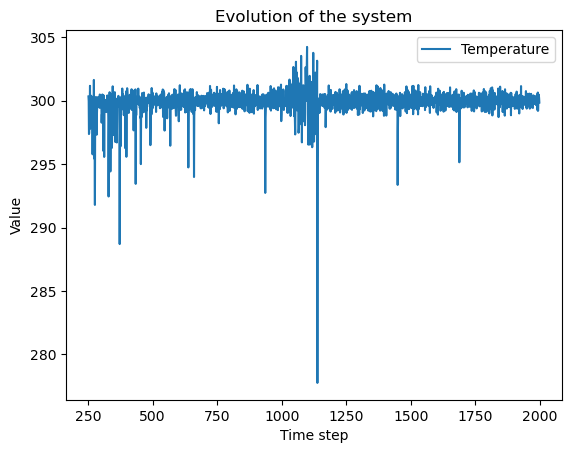

In [9]:
#plot the evolutions
plt.plot(step_[250:1998], T_i_[250:1998], label='Temperature')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Evolution of the system')
plt.legend()
plt.show()

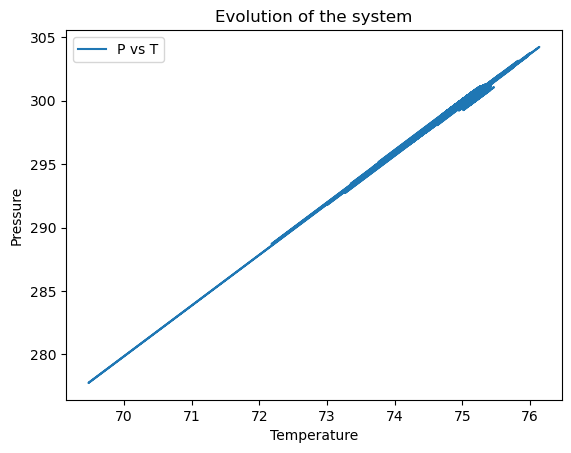

In [10]:
plt.plot(P_[250:1998], T_i_[250:1998], label='P vs T')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.title('Evolution of the system')
plt.legend()
plt.show()

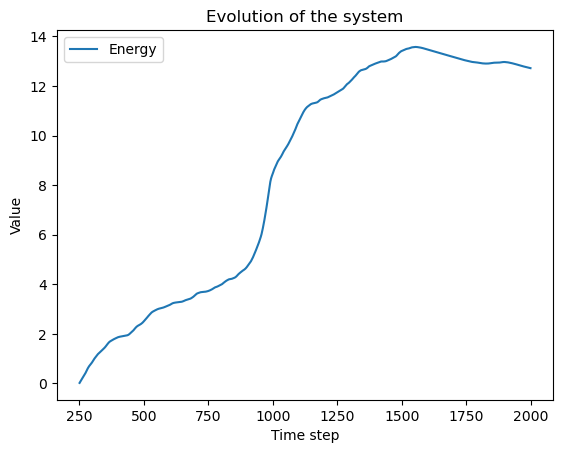

In [11]:
plt.plot(step_[250:1998], PE_[250:1998], label='Energy')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Evolution of the system')
plt.legend()
plt.show()